# Predict Tropical Storm Trajectory In Western Pacific 

# Crawling storm data

- Data source: https://ncics.org/ (north carolina institute for climate studies)
- Web scraping and data extraction from a structured table
- Save data in to CSV file

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

def take_hrefs(url: str):
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find_all('table')[-1]
    hrefs = []

    for a in table.find_all('a', href=True):
        hrefs.append(a['href'])

    return hrefs

def crawl_data(hrefs: list):
    base_url = 'https://ncics.org/ibtracs/'
    csv_file = "storm_data.csv"
    
    for href in hrefs:
        url = base_url + href
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        table = soup.find_all('table')[-1]

        header = [th.get_text(strip=True) for th in table.find_all('th')]

        data = []
        for tr in table.find_all('tr')[1:]:  # Skip header row
            row = [td.get_text(strip=True) for td in tr.find_all('td')]
            data.append(row)

        df_new = pd.DataFrame(data, columns=header)
        if os.path.exists(csv_file):
            df_existing = pd.read_csv(csv_file)
            df_merged = pd.concat([df_existing, df_new], ignore_index=True, sort=False)
            df_merged.to_csv(csv_file, index=False)

        else:
            df_new.to_csv(csv_file, index=False)

    print(f"Data has been saved successfully.")


url = 'https://ncics.org/ibtracs/index.php?name=ATCF-WP'
crawl_data(take_hrefs(url))

C:\Users\admin\AppData\Local\Temp\ipykernel_3248\3302244835.py:36: DtypeWarning: Columns (0,6,8,13,15,16,18,19,20,21,22,23,24,27,28,29,31,32,33,35,36,38,39,41,42,43,46,49,51,52,53,54,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(csv_file)
C:\Users\admin\AppData\Local\Temp\ipykernel_3248\3302244835.py:36: DtypeWarning: Columns (49,51,52,53,54,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(csv_file)
C:\Users\admin\AppData\Local\Temp\ipykernel_3248\3302244835.py:36: DtypeWarning: Columns (52,53,54,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(csv_file)
C:\Users\admin\AppData\Local\Temp\ipykernel_3248\3302244835.py:36: DtypeWarning: Columns (53,54,55,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_existing = pd.read_csv(csv_file)
C:\Users\admin\AppData\Local\

Data has been saved successfully.


# Data Exploration and Pre-processing Data
Methodology:
- Drop metadata lines
- Choosing attributes for model
- Pre-processing data types
- Pre-processing null values


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


Read CSV file

In [31]:
data = pd.read_csv('storm_data.csv')
data.head(5)


C:\Users\admin\AppData\Local\Temp\ipykernel_11356\1962646088.py:1: DtypeWarning: Columns (15,17,18,19,20,23,24,25,26,27,28,29,31,32,33,35,36,42,43,44,46,47,48,49,51,52,53,54,55,57,58,60,62,63,64,65,67,68,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('storm_data.csv')


SEASON BASIN SUBBASIN               ISO_TIME_________ NATURE   LAT  \
0   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN   NaN   
1   2024    WP       MM             2024-05-24 18:00:00     NR  11.2   
2   2024    WP       MM                        21:00:00     NR  11.8   
3   2024    WP       MM             2024-05-25 00:00:00     NR  12.3   
4   2024    WP       MM                        03:00:00     NR  12.6   

             LON  DIST2LAND LANDFALL            IFLAG  ... DS824 LAT  \
0  degrees north        NaN       km               km  ...       NaN   
1         125.50        0.0        0  O______________  ...       NaN   
2         124.80       10.0       10  P______________  ...       NaN   
3         124.10       22.0       15  O______________  ...       NaN   
4         123.50       15.0       11  P______________  ...       NaN   

  DS824 LON  DS824 STAGE DS824 WIND  DS824 PRES TD9635 LAT TD9635 LON  \
0       NaN          NaN        NaN         NaN        NaN        NaN   
1       NaN          NaN        NaN         NaN        NaN        NaN   
2       NaN          NaN        NaN         NaN        NaN        NaN   
3       NaN          NaN        NaN         NaN        NaN        NaN   
4       NaN          NaN        NaN         NaN        NaN        NaN   

  TD9635 WIND TD9635 PRES TD9635 ROCI  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN  

[5 rows x 75 columns]

Checking this columns 15,17,18,19,20,23,24,25,26,27,28,29,31,32,33,35,36,42,43,44,46,47,48,49,51,52,53,54,55,57,58,60,62,63,64,65,67,68,69,70,71,72,73

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169871 entries, 0 to 169870
Data columns (total 75 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SEASON             169871 non-null  object 
 1   BASIN              167562 non-null  object 
 2   SUBBASIN           167562 non-null  object 
 3   ISO_TIME_________  169871 non-null  object 
 4   NATURE             167562 non-null  object 
 5   LAT                167562 non-null  float64
 6   LON                169871 non-null  object 
 7   DIST2LAND          167562 non-null  float64
 8   LANDFALL           167561 non-null  object 
 9   IFLAG              169871 non-null  object 
 10  USA AGENCY         66355 non-null   object 
 11  USA ATCF_ID        132229 non-null  object 
 12  USA LAT            130577 non-null  float64
 13  USA LON            132886 non-null  object 
 14  USA WIND           129336 non-null  float64
 15  USA PRES           36973 non-null   object 
 16  US

## Drop metadata lines
Each storm have 1 line contain meta data for that storm, where SEASON is Year

In [33]:
null_df = data[data['SEASON'] == 'Year']
null_df

SEASON BASIN SUBBASIN               ISO_TIME_________ NATURE  LAT  \
0        Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
52       Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
62       Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
68       Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
98       Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
...       ...   ...      ...                             ...    ...  ...   
169591   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
169657   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
169739   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
169767   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   
169789   Year   NaN      NaN  days since 1858-11-17 00:00:00    NaN  NaN   

                  LON  DIST2LAND LANDFALL IFLAG  ... DS824 LAT DS824 LON  \
0       degrees north        NaN       km    km  ...       NaN       NaN   
52      degrees north        NaN       km    km  ...       NaN       NaN   
62      degrees north        NaN       km    km  ...       NaN       NaN   
68      degrees north        NaN       km    km  ...       NaN       NaN   
98      degrees north        NaN       km    km  ...       NaN       NaN   
...               ...        ...      ...   ...  ...       ...       ...   
169591  degrees north        NaN       km    km  ...     nmile       NaN   
169657  degrees north        NaN       km    km  ...     nmile       NaN   
169739  degrees north        NaN       km    km  ...     nmile       NaN   
169767  degrees north        NaN       km    km  ...     nmile       NaN   
169789  degrees north        NaN       km    km  ...     nmile       NaN   

        DS824 STAGE     DS824 WIND  DS824 PRES TD9635 LAT TD9635 LON  \
0               NaN            NaN         NaN        NaN        NaN   
52              NaN            NaN         NaN        NaN        NaN   
62              NaN            NaN         NaN        NaN        NaN   
68              NaN            NaN         NaN        NaN        NaN   
98              NaN            NaN         NaN        NaN        NaN   
...             ...            ...         ...        ...        ...   
169591          NaN  degrees north         NaN        kts         mb   
169657          NaN  degrees north         NaN        kts         mb   
169739          NaN  degrees north         NaN        kts         mb   
169767          NaN  degrees north         NaN        kts         mb   
169789          NaN  degrees north         NaN        kts         mb   

          TD9635 WIND   TD9635 PRES TD9635 ROCI  
0                 NaN           NaN         NaN  
52                NaN           NaN         NaN  
62                NaN           NaN         NaN  
68                NaN           NaN         NaN  
98                NaN           NaN         NaN  
...               ...           ...         ...  
169591  degrees north  degrees east         NaN  
169657  degrees north  degrees east         NaN  
169739  degrees north  degrees east         NaN  
169767  degrees north  degrees east         NaN  
169789  degrees north  degrees east         NaN  

[2309 rows x 75 columns]

2309 rows above is meta data for 2309 storms in data set

So I will drop all of this

In [34]:
data.drop(data[data['SEASON'] == 'Year'].index, inplace=True)
data.shape

(167562, 75)

## Choosing attributes for model
Choosing criteria:
- Affect to storm trajectory and category
- Have minimum null values

Checking null values percentage

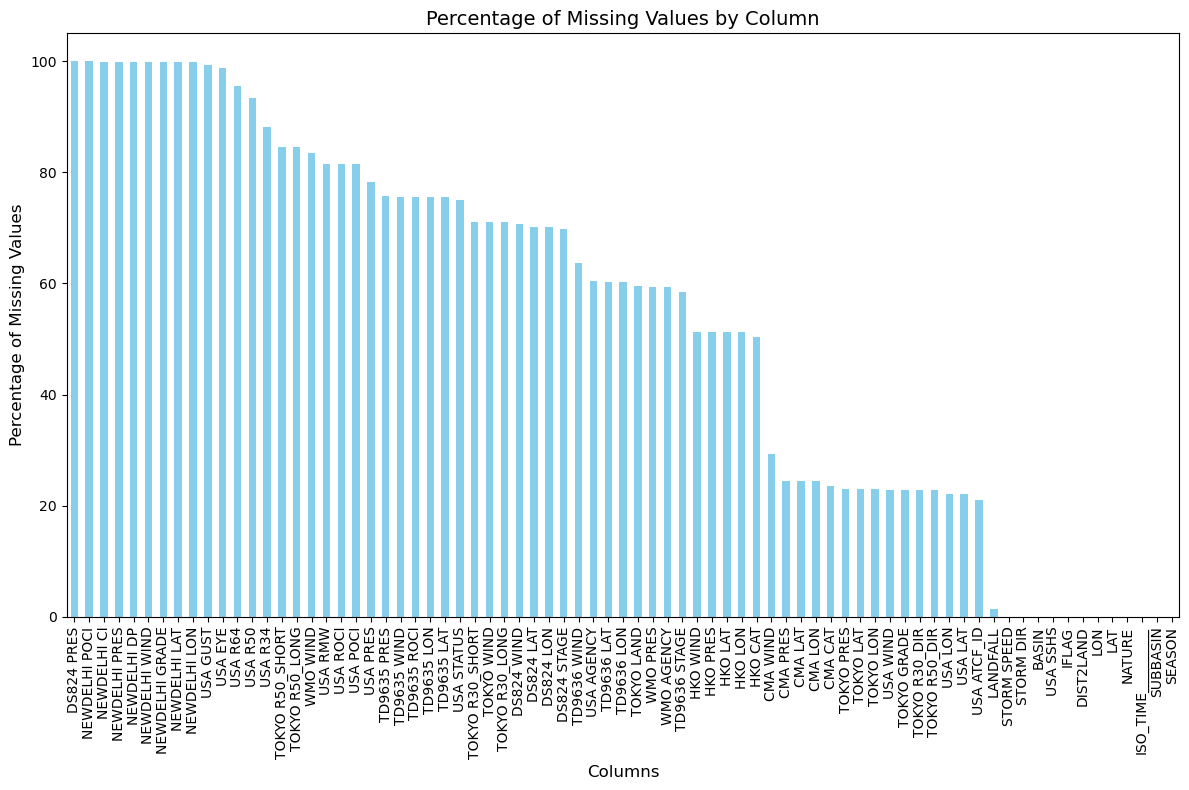

In [35]:
missing_values_percent = data.isnull().mean() * 100

plt.figure(figsize=(12,8))
missing_values_percent[missing_values_percent >= 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Missing Values', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Drop Attributes:
- Drop SEASON, BASIN, SUBBASIN, USA AGENCY, USA ATCF_ID, and WMO AGENCY because they do not contain any information about storm trajectory prediction.
- For attributes measured by various agencies, I will choose the attribute with the minimum missing value percentage or where the missing value percentage is ≥ 50%.

Attributes Remaining After Drops:
- Year
- NATURE
- LAT

- LON

- DIST2LAND 

- LANDFALL

- WIND

- PRES

- SSHS

- POCI

- ROCI

- RMW

- STORM SPEED

- STORM DIR

Drop columns SEASON, BASIN, SUBBASIN, IFLAG, USA AGENCY, USA ATCF_ID



In [36]:
columns_to_keep = [
    'SEASON',
    'NATURE',
    'LAT',
    'LON',
    'DIST2LAND',
    'LANDFALL',
    'USA WIND',
    'TOKYO PRES',
    'USA SSHS',
    'USA POCI',
    'USA ROCI',
    'USA RMW',
    'STORM SPEED',
    'STORM DIR',
]
final_data = data[columns_to_keep]
final_data.shape

(167562, 14)

In [37]:
final_data.head(5)

SEASON NATURE   LAT     LON  DIST2LAND LANDFALL  USA WIND TOKYO PRES  \
1   2024     NR  11.2  125.50        0.0        0      25.0        NaN   
2   2024     NR  11.8  124.80       10.0       10      27.0        NaN   
3   2024     NR  12.3  124.10       22.0       15      29.0        NaN   
4   2024     NR  12.6  123.50       15.0       11      29.0        NaN   
5   2024     NR  12.8  123.00       39.0       11      29.0        NaN   

  USA SSHS USA POCI USA ROCI USA RMW STORM SPEED STORM DIR  
1       -1     1006      139      22          19       310  
2       -1     1006      139      22          18       310  
3       -1     1006      139      22          15       300  
4       -1     1009      139      22          12       295  
5       -1     1011      139      22          11       300

In [38]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167562 entries, 1 to 169870
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SEASON       167562 non-null  object 
 1   NATURE       167562 non-null  object 
 2   LAT          167562 non-null  float64
 3   LON          167562 non-null  object 
 4   DIST2LAND    167562 non-null  float64
 5   LANDFALL     165253 non-null  object 
 6   USA WIND     129336 non-null  float64
 7   TOKYO PRES   128910 non-null  object 
 8   USA SSHS     167562 non-null  object 
 9   USA POCI     31016 non-null   object 
 10  USA ROCI     30954 non-null   object 
 11  USA RMW      30943 non-null   object 
 12  STORM SPEED  167561 non-null  object 
 13  STORM DIR    167561 non-null  object 
dtypes: float64(3), object(11)
memory usage: 19.2+ MB


## Pre-processing data types
Methodology:
- Categorycal data: convert it to number.
- Numberic data: correct data type

### Overview

In [39]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167562 entries, 1 to 169870
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SEASON       167562 non-null  object 
 1   NATURE       167562 non-null  object 
 2   LAT          167562 non-null  float64
 3   LON          167562 non-null  object 
 4   DIST2LAND    167562 non-null  float64
 5   LANDFALL     165253 non-null  object 
 6   USA WIND     129336 non-null  float64
 7   TOKYO PRES   128910 non-null  object 
 8   USA SSHS     167562 non-null  object 
 9   USA POCI     31016 non-null   object 
 10  USA ROCI     30954 non-null   object 
 11  USA RMW      30943 non-null   object 
 12  STORM SPEED  167561 non-null  object 
 13  STORM DIR    167561 non-null  object 
dtypes: float64(3), object(11)
memory usage: 19.2+ MB


Season column 

Contain year of storm, chage datatype of season column to numberic

In [40]:
final_data['SEASON'] = pd.to_numeric(final_data['SEASON'], errors='coerce')
SEASON_datatype = final_data['SEASON'].dtypes
SEASON_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\96913618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['SEASON'] = pd.to_numeric(final_data['SEASON'], errors='coerce')


dtype('int64')

### Nature column

NATURE: Type of storm (tropical, extratropical).

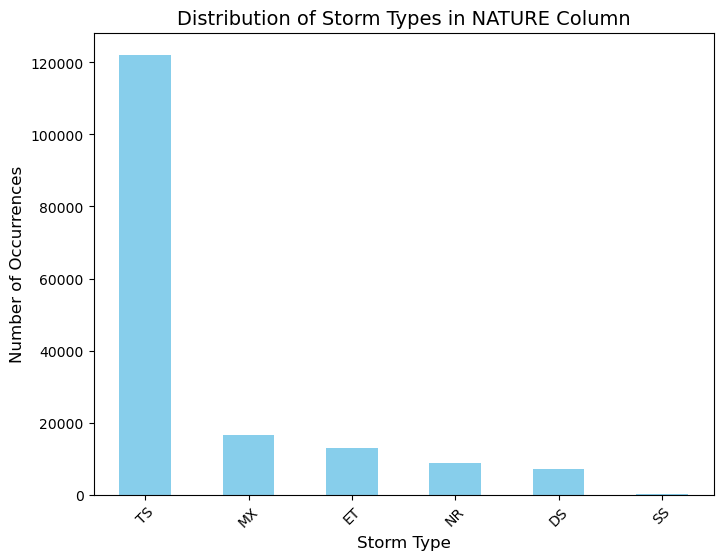

In [41]:
plt.figure(figsize=(8, 6))
final_data['NATURE'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Storm Types in NATURE Column', fontsize=14)
plt.xlabel('Storm Type', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

plt.xticks(rotation=45) 
plt.show()

Meaning of values:

- DS (Disturbance): A weak, unorganized weather system, often a precursor to tropical storms.
- ET (Extratropical Cyclone): A cyclone that forms outside the tropics, driven by atmospheric dynamics rather than warm ocean waters.
- MX (Mixed Cyclone or Mesocyclone): A storm with both tropical and extratropical characteristics or a rotating updraft in a storm.
- NR (No Record): Indicates missing or unavailable data regarding the storm type.
- SS (Subtropical Storm): A hybrid system with characteristics of both tropical and extratropical storms, often less organized than a tropical storm.
- TS (Tropical Storm): A well-organized storm system with sustained winds of 39-73 mph (34-63 knots).

I will change value of NR to TS because it have most frequency

Convert categorical data to numberic

In [42]:
final_data.loc[final_data['NATURE'] == 'NR', 'NATURE'] = 'TS'
number_of_natural = final_data['NATURE'].value_counts()
number_of_natural

NATURE
TS    131077
MX     16495
ET     12954
DS      6988
SS        48
Name: count, dtype: int64

In [43]:
label_encoder = LabelEncoder()
final_data['NATURE'] = label_encoder.fit_transform(final_data['NATURE'])

label_mapping_nature = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping_nature

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\1378285162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['NATURE'] = label_encoder.fit_transform(final_data['NATURE'])


{'DS': 0, 'ET': 1, 'MX': 2, 'SS': 3, 'TS': 4}

### LON column

We see that all row in dataset are not float64, so we need to convert it in correct datatype

In [44]:
final_data['LON'] = pd.to_numeric(final_data['LON'], errors='coerce')
LON_datatype = final_data['LON'].dtypes
LON_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\4152113167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['LON'] = pd.to_numeric(final_data['LON'], errors='coerce')


dtype('float64')

### LANDFALL

LANDFALL is special column because when the value of this column is null that mean the storm dissapear

In [45]:
final_data['LANDFALL'] = pd.to_numeric(final_data['LANDFALL'], errors='coerce')
LANDFALL_datatype = final_data['LANDFALL'].dtypes
LANDFALL_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\3193826136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['LANDFALL'] = pd.to_numeric(final_data['LANDFALL'], errors='coerce')


dtype('float64')

### TOKYO PRES(in hPa)

Convert to float64

In [46]:
final_data['TOKYO PRES'] = pd.to_numeric(final_data['TOKYO PRES'], errors='coerce')
TOKYO_PRES_datatype = final_data['TOKYO PRES'].dtypes
TOKYO_PRES_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\179803073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['TOKYO PRES'] = pd.to_numeric(final_data['TOKYO PRES'], errors='coerce')


dtype('float64')

### USA SSHS is category scale for storm
Value in range (-5; 5)

In [47]:
final_data['USA SSHS'] = pd.to_numeric(final_data['USA SSHS'], errors='coerce')
USA_SSHS_datatype = final_data['USA SSHS'].dtypes
USA_SSHS_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\417851070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['USA SSHS'] = pd.to_numeric(final_data['USA SSHS'], errors='coerce')


dtype('int64')

### STORM SPEED column

In [48]:
final_data['STORM SPEED'] = pd.to_numeric(final_data['STORM SPEED'], errors='coerce')
STORM_SPEED_datatype = final_data['STORM SPEED'].dtypes
STORM_SPEED_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\2705977193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['STORM SPEED'] = pd.to_numeric(final_data['STORM SPEED'], errors='coerce')


dtype('float64')

### STORM DIR

In [49]:
final_data['STORM DIR'] = pd.to_numeric(final_data['STORM DIR'], errors='coerce')
STORM_DIR_datatype = final_data['STORM DIR'].dtypes
STORM_DIR_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\1771876568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['STORM DIR'] = pd.to_numeric(final_data['STORM DIR'], errors='coerce')


dtype('float64')

### USA POCI

In [50]:
final_data['USA POCI'] = pd.to_numeric(final_data['USA POCI'], errors='coerce')
USA_POCI_datatype = final_data['USA POCI'].dtypes
USA_POCI_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\2407449847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['USA POCI'] = pd.to_numeric(final_data['USA POCI'], errors='coerce')


dtype('float64')

### USA ROCI

In [51]:
final_data['USA ROCI'] = pd.to_numeric(final_data['USA ROCI'], errors='coerce')
USA_ROCI_datatype = final_data['USA ROCI'].dtypes
USA_ROCI_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\235208662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['USA ROCI'] = pd.to_numeric(final_data['USA ROCI'], errors='coerce')


dtype('float64')

### USA RMW

In [52]:
final_data['USA RMW'] = pd.to_numeric(final_data['USA RMW'], errors='coerce')
USA_RMW_datatype = final_data['USA RMW'].dtypes
USA_RMW_datatype

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\1716376383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['USA RMW'] = pd.to_numeric(final_data['USA RMW'], errors='coerce')


dtype('float64')

### Final result

In [53]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 167562 entries, 1 to 169870
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SEASON       167562 non-null  int64  
 1   NATURE       167562 non-null  int32  
 2   LAT          167562 non-null  float64
 3   LON          167562 non-null  float64
 4   DIST2LAND    167562 non-null  float64
 5   LANDFALL     165253 non-null  float64
 6   USA WIND     129336 non-null  float64
 7   TOKYO PRES   128910 non-null  float64
 8   USA SSHS     167562 non-null  int64  
 9   USA POCI     31016 non-null   float64
 10  USA ROCI     30954 non-null   float64
 11  USA RMW      30943 non-null   float64
 12  STORM SPEED  167561 non-null  float64
 13  STORM DIR    167561 non-null  float64
dtypes: float64(11), int32(1), int64(2)
memory usage: 18.5 MB


## Pre-processing null values
Methodology:
- For columns with missing values, check for data from other agencies to fill in the gaps.
- Using data from relative columns to calculate mean
- Using interpolation to predict null values
- If no data from other sources is available, use statistical methods such as confidence intervals, mean, median, or standard deviation to fill in the missing data
- Take average results of multiple methods to get best result

Checking missing values

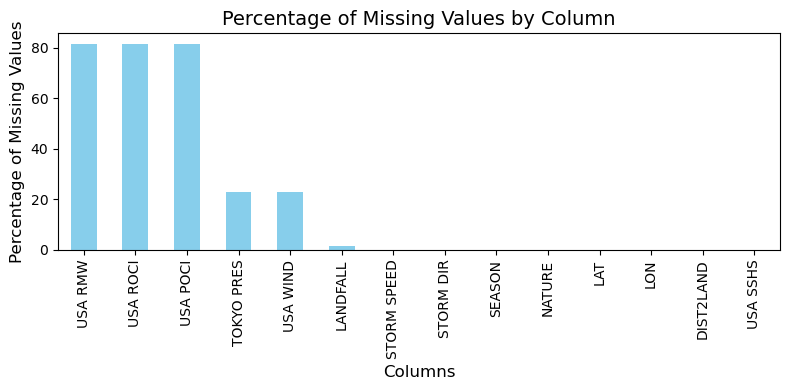

In [54]:
missing_values_percent = final_data.isnull().mean() * 100

plt.figure(figsize=(8,4))
missing_values_percent[missing_values_percent >= 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Percentage of Missing Values', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### LANDFALL column
There are 2309 storms and if row have landfall is null show that storm is end

In [55]:
null_landfall_data = final_data['LANDFALL'].isnull().sum()
null_landfall_data

2309

Change value null of LANDFALL to -1

In [56]:
final_data['LANDFALL'] = final_data['LANDFALL'].fillna(-1)


C:\Users\admin\AppData\Local\Temp\ipykernel_11356\529765917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['LANDFALL'] = final_data['LANDFALL'].fillna(-1)


In [57]:
null_landfall_data = final_data['LANDFALL'].isnull().sum()
null_landfall_data

0

### TOKYO PRES
About column TOKYO PRES, I will take data from other agency for example: USA PRES, CMA PRES, NEWDELHI PRES, DS824 PRES, TD9635 PRES and change name of column to STORM PRES

In [58]:

final_data.loc[:, 'TOKYO PRES'] = final_data['TOKYO PRES'].fillna(data['USA PRES'])
final_data.loc[:, 'TOKYO PRES'] = final_data['TOKYO PRES'].fillna(data['CMA PRES'])
final_data.loc[:, 'TOKYO PRES'] = final_data['TOKYO PRES'].fillna(data['NEWDELHI PRES'])
final_data.loc[:, 'TOKYO PRES'] = final_data['TOKYO PRES'].fillna(data['DS824 PRES'])
final_data.loc[:, 'TOKYO PRES'] = final_data['TOKYO PRES'].fillna(data['TD9635 PRES'])
final_data['TOKYO PRES'] = pd.to_numeric(final_data['TOKYO PRES'], errors='coerce')
final_data.rename(columns={'TOKYO PRES': 'STORM PRES'}, inplace=True)



C:\Users\admin\AppData\Local\Temp\ipykernel_11356\497819049.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['TOKYO PRES'] = pd.to_numeric(final_data['TOKYO PRES'], errors='coerce')
C:\Users\admin\AppData\Local\Temp\ipykernel_11356\497819049.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.rename(columns={'TOKYO PRES': 'STORM PRES'}, inplace=True)


In [59]:
null_storm_pres_count = final_data['STORM PRES'].isnull().sum()
null_storm_pres_count

15867

In [60]:
null_storm_pres_des = final_data['STORM PRES'].describe(include=[np.number])
null_storm_pres_des

count    151695.000000
mean        986.433930
std          21.574462
min         870.000000
25%         978.000000
50%         994.000000
75%        1002.000000
max        1022.000000
Name: STORM PRES, dtype: float64

The standard deviation is not too large, so I will use the mean to fill all null values

In [61]:
mean_value = final_data['STORM PRES'].mean()
final_data['STORM PRES'].fillna(mean_value, inplace=True)
null_storm_pres_count = final_data['STORM PRES'].isnull().sum()
null_storm_pres_count

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\2969964756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['STORM PRES'].fillna(mean_value, inplace=True)


0

### Apply in USA WIND

In [62]:

final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['WMO WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['TOKYO WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['CMA WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['HKO WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['NEWDELHI WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['TD9636 WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['DS824 WIND'])
final_data.loc[:, 'USA WIND'] = final_data['USA WIND'].fillna(data['TD9635 WIND'])


final_data['USA WIND'] = pd.to_numeric(final_data['USA WIND'], errors='coerce')


final_data.rename(columns={'USA WIND': 'WIND_SPEED'}, inplace=True)


C:\Users\admin\AppData\Local\Temp\ipykernel_11356\3722751447.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['USA WIND'] = pd.to_numeric(final_data['USA WIND'], errors='coerce')
C:\Users\admin\AppData\Local\Temp\ipykernel_11356\3722751447.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.rename(columns={'USA WIND': 'WIND_SPEED'}, inplace=True)


In [63]:
print(final_data['WIND_SPEED'].isnull().sum())  

19441


Checking relative between WIND_SPEED and SSHS

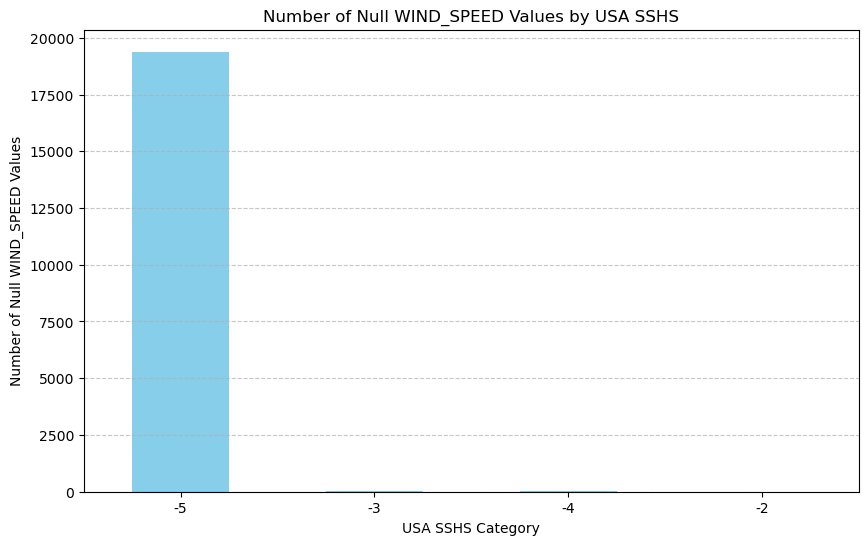

In [64]:
null_counts = final_data[final_data['WIND_SPEED'].isnull()]['USA SSHS'].value_counts()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Null WIND_SPEED Values by USA SSHS')
plt.xlabel('USA SSHS Category')
plt.ylabel('Number of Null WIND_SPEED Values')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

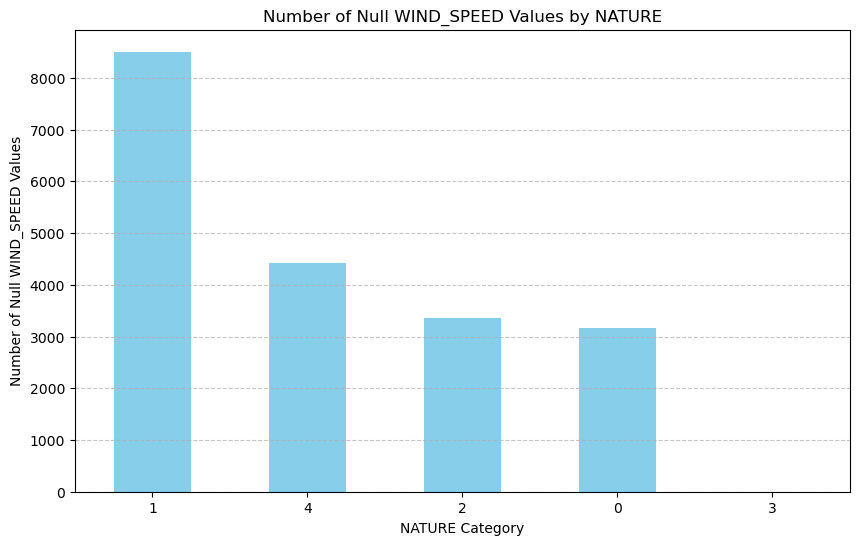

In [65]:
null_counts = final_data[final_data['WIND_SPEED'].isnull()]['NATURE'].value_counts()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Null WIND_SPEED Values by NATURE')
plt.xlabel('NATURE Category')
plt.ylabel('Number of Null WIND_SPEED Values')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

I see that WIND_SPEED with NATURE have better distribution so I will use it to full fill data frame and after one row is filled I will recalculate mean

In [66]:
initial_mean_wind_speed = final_data['WIND_SPEED'].mean()

for index, row in final_data.iterrows():
    if pd.isnull(row['WIND_SPEED']):
        mean_wind_speed_by_nature = final_data[final_data['NATURE'] == row['NATURE']]['WIND_SPEED'].mean()
        
        if not pd.isnull(mean_wind_speed_by_nature):
            final_data.at[index, 'WIND_SPEED'] = mean_wind_speed_by_nature

        overall_mean_wind_speed = final_data['WIND_SPEED'].mean()

In [67]:
print(final_data['WIND_SPEED'].isnull().sum()) 

0


### USA POCI column

Number of null values

In [68]:
print(final_data['USA POCI'].isnull().sum())

136546


There are no matched attribute and it have to many null values

I suggest that using KNN Imputer

Below here is code to find optimal k for KNN

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error


def find_optimal_k(final_data, feature_col, target_col, k_min, k_max):
    df_non_null = final_data[final_data[target_col].notnull()]
    df_null = final_data[final_data[target_col].isnull()]
    X_train = df_non_null[[feature_col]]  # Feature
    y_train = df_non_null[target_col]     # Target
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    k_values = range(k_min, k_max)
    errors = []

    for k in k_values:
        knn_regressor = KNeighborsRegressor(n_neighbors=k)
        knn_regressor.fit(X_train_scaled, y_train)
        y_train_pred = knn_regressor.predict(X_train_scaled)
        mae = mean_absolute_error(y_train, y_train_pred)
        errors.append(mae)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, errors, marker='o')
    plt.title('Elbow Method for Optimal k (KNN)')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.xticks(k_values)
    plt.grid()
    plt.show()


This code below is def for predict missing value

In [70]:

def predict_missing_values_knn(final_data, feature_col, target_col, k):
    df_non_null = final_data[final_data[target_col].notnull()]
    df_null = final_data[final_data[target_col].isnull()]
    X_train = df_non_null[[feature_col]]  # Feature
    y_train = df_non_null[target_col]     # Target

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test = df_null[[feature_col]]
    X_test_scaled = scaler.transform(X_test)
    
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train_scaled, y_train)
    y_pred = knn_regressor.predict(X_test_scaled)

    final_data.loc[final_data[target_col].isnull(), target_col] = y_pred
    return final_data

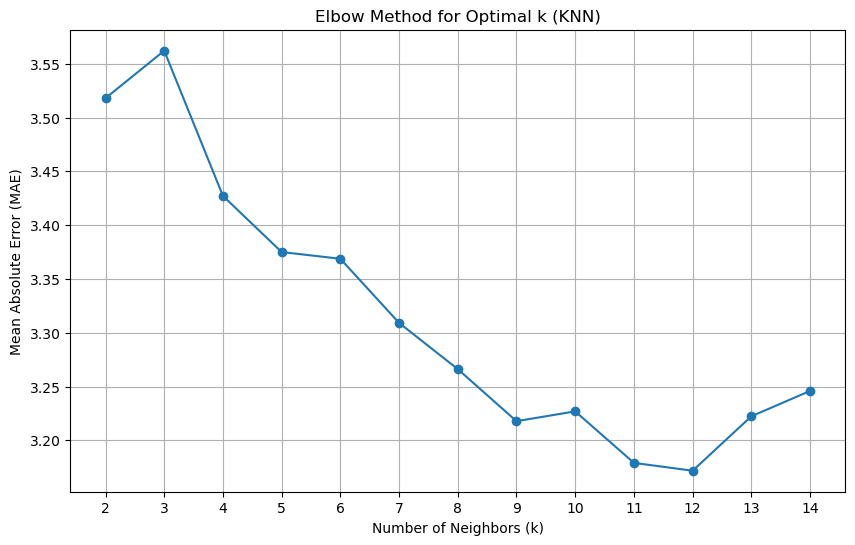

In [71]:
find_optimal_k(final_data, feature_col='USA SSHS', target_col='USA POCI', k_min=2, k_max=15)

So k = 12 is most optimal

In [72]:
predict_missing_values_knn(final_data, feature_col='USA SSHS', target_col='USA POCI', k=12)

SEASON  NATURE   LAT    LON  DIST2LAND  LANDFALL  WIND_SPEED  \
1         2024       4  11.2  125.5        0.0       0.0   25.000000   
2         2024       4  11.8  124.8       10.0      10.0   27.000000   
3         2024       4  12.3  124.1       22.0      15.0   29.000000   
4         2024       4  12.6  123.5       15.0      11.0   29.000000   
5         2024       4  12.8  123.0       39.0      11.0   29.000000   
...        ...     ...   ...    ...        ...       ...         ...   
169866    1945       4  23.7  149.7     1565.0    1565.0   54.307034   
169867    1945       4  24.0  150.5     1583.0    1583.0   54.307034   
169868    1945       4  24.3  151.2     1598.0    1598.0   54.307034   
169869    1945       4  24.6  152.0     1624.0    1622.0   54.307034   
169870    1945       4  24.9  152.7     1646.0      -1.0   54.307034   

        STORM PRES  USA SSHS     USA POCI  USA ROCI  USA RMW  STORM SPEED  \
1       1004.00000        -1  1006.000000     139.0     22.0         19.0   
2       1004.00000        -1  1006.000000     139.0     22.0         18.0   
3       1003.00000        -1  1006.000000     139.0     22.0         15.0   
4       1003.00000        -1  1009.000000     139.0     22.0         12.0   
5       1003.00000        -1  1011.000000     139.0     22.0         11.0   
...            ...       ...          ...       ...      ...          ...   
169866   986.43393        -5  1003.916667       NaN      NaN         15.0   
169867   986.43393        -5  1003.916667       NaN      NaN         15.0   
169868   986.43393        -5  1003.916667       NaN      NaN         15.0   
169869   986.43393        -5  1003.916667       NaN      NaN         15.0   
169870   986.43393        -5  1003.916667       NaN      NaN         15.0   

        STORM DIR  
1           310.0  
2           310.0  
3           300.0  
4           295.0  
5           300.0  
...           ...  
169866       70.0  
169867       70.0  
169868       65.0  
169869       65.0  
169870       65.0  

[167562 rows x 14 columns]

In [73]:
print(final_data['USA POCI'].isnull().sum())

0


### USA ROCI

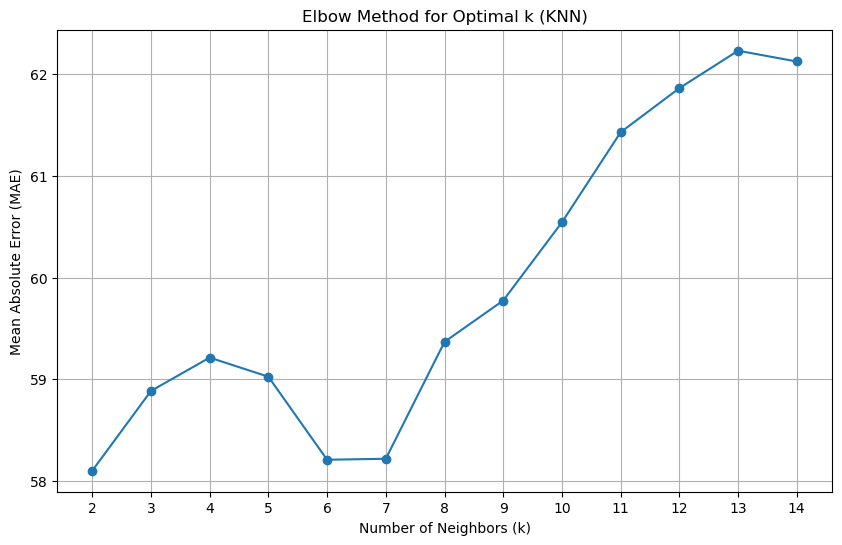

In [74]:
find_optimal_k(final_data, feature_col='USA SSHS', target_col='USA ROCI', k_min=2, k_max=15)

So optimal k is 6

In [75]:
predict_missing_values_knn(final_data, feature_col='USA SSHS', target_col='USA ROCI', k=6)

SEASON  NATURE   LAT    LON  DIST2LAND  LANDFALL  WIND_SPEED  \
1         2024       4  11.2  125.5        0.0       0.0   25.000000   
2         2024       4  11.8  124.8       10.0      10.0   27.000000   
3         2024       4  12.3  124.1       22.0      15.0   29.000000   
4         2024       4  12.6  123.5       15.0      11.0   29.000000   
5         2024       4  12.8  123.0       39.0      11.0   29.000000   
...        ...     ...   ...    ...        ...       ...         ...   
169866    1945       4  23.7  149.7     1565.0    1565.0   54.307034   
169867    1945       4  24.0  150.5     1583.0    1583.0   54.307034   
169868    1945       4  24.3  151.2     1598.0    1598.0   54.307034   
169869    1945       4  24.6  152.0     1624.0    1622.0   54.307034   
169870    1945       4  24.9  152.7     1646.0      -1.0   54.307034   

        STORM PRES  USA SSHS     USA POCI  USA ROCI  USA RMW  STORM SPEED  \
1       1004.00000        -1  1006.000000     139.0     22.0         19.0   
2       1004.00000        -1  1006.000000     139.0     22.0         18.0   
3       1003.00000        -1  1006.000000     139.0     22.0         15.0   
4       1003.00000        -1  1009.000000     139.0     22.0         12.0   
5       1003.00000        -1  1011.000000     139.0     22.0         11.0   
...            ...       ...          ...       ...      ...          ...   
169866   986.43393        -5  1003.916667     245.0      NaN         15.0   
169867   986.43393        -5  1003.916667     245.0      NaN         15.0   
169868   986.43393        -5  1003.916667     245.0      NaN         15.0   
169869   986.43393        -5  1003.916667     245.0      NaN         15.0   
169870   986.43393        -5  1003.916667     245.0      NaN         15.0   

        STORM DIR  
1           310.0  
2           310.0  
3           300.0  
4           295.0  
5           300.0  
...           ...  
169866       70.0  
169867       70.0  
169868       65.0  
169869       65.0  
169870       65.0  

[167562 rows x 14 columns]

In [76]:
print(final_data['USA ROCI'].isnull().sum())

0


### USA RMW

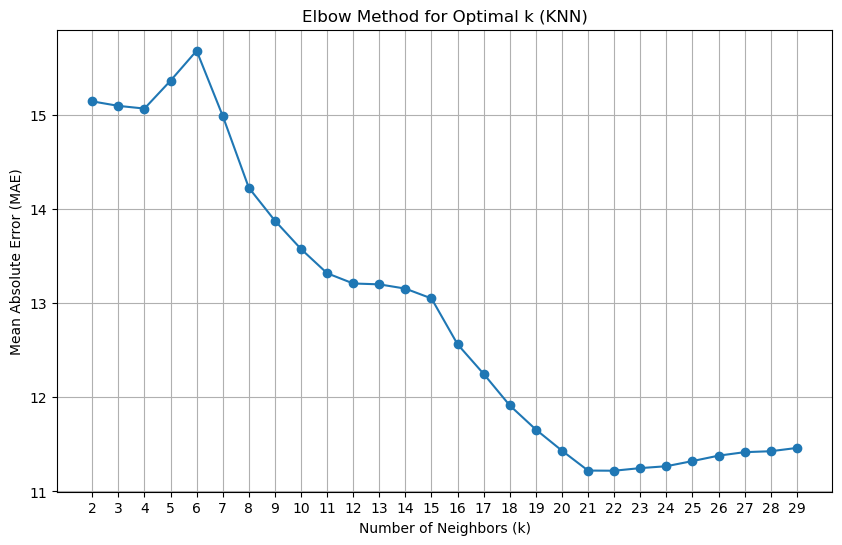

In [77]:
find_optimal_k(final_data, feature_col='USA SSHS', target_col='USA RMW', k_min=2, k_max=30)

Optimal k = 21

In [78]:
predict_missing_values_knn(final_data, feature_col='USA SSHS', target_col='USA RMW', k=21)

SEASON  NATURE   LAT    LON  DIST2LAND  LANDFALL  WIND_SPEED  \
1         2024       4  11.2  125.5        0.0       0.0   25.000000   
2         2024       4  11.8  124.8       10.0      10.0   27.000000   
3         2024       4  12.3  124.1       22.0      15.0   29.000000   
4         2024       4  12.6  123.5       15.0      11.0   29.000000   
5         2024       4  12.8  123.0       39.0      11.0   29.000000   
...        ...     ...   ...    ...        ...       ...         ...   
169866    1945       4  23.7  149.7     1565.0    1565.0   54.307034   
169867    1945       4  24.0  150.5     1583.0    1583.0   54.307034   
169868    1945       4  24.3  151.2     1598.0    1598.0   54.307034   
169869    1945       4  24.6  152.0     1624.0    1622.0   54.307034   
169870    1945       4  24.9  152.7     1646.0      -1.0   54.307034   

        STORM PRES  USA SSHS     USA POCI  USA ROCI  USA RMW  STORM SPEED  \
1       1004.00000        -1  1006.000000     139.0     22.0         19.0   
2       1004.00000        -1  1006.000000     139.0     22.0         18.0   
3       1003.00000        -1  1006.000000     139.0     22.0         15.0   
4       1003.00000        -1  1009.000000     139.0     22.0         12.0   
5       1003.00000        -1  1011.000000     139.0     22.0         11.0   
...            ...       ...          ...       ...      ...          ...   
169866   986.43393        -5  1003.916667     245.0     59.0         15.0   
169867   986.43393        -5  1003.916667     245.0     59.0         15.0   
169868   986.43393        -5  1003.916667     245.0     59.0         15.0   
169869   986.43393        -5  1003.916667     245.0     59.0         15.0   
169870   986.43393        -5  1003.916667     245.0     59.0         15.0   

        STORM DIR  
1           310.0  
2           310.0  
3           300.0  
4           295.0  
5           300.0  
...           ...  
169866       70.0  
169867       70.0  
169868       65.0  
169869       65.0  
169870       65.0  

[167562 rows x 14 columns]

In [79]:
print(final_data['USA RMW'].isnull().sum())

0


### STORM SPEED

In [80]:
print(final_data['STORM SPEED'].isnull().sum())

1


Fill null values with the value from the row above in each column

In [81]:
final_data.fillna(method='ffill', inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_11356\3089142934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.fillna(method='ffill', inplace=True)


In [82]:
print(final_data['STORM SPEED'].isnull().sum())

0


### STROM DIR

In [83]:
print(final_data['STORM DIR'].isnull().sum())

0


### Final result

In [85]:
final_data.isnull().sum()

SEASON         0
NATURE         0
LAT            0
LON            0
DIST2LAND      0
LANDFALL       0
WIND_SPEED     0
STORM PRES     0
USA SSHS       0
USA POCI       0
USA ROCI       0
USA RMW        0
STORM SPEED    0
STORM DIR      0
dtype: int64

## Checking for duplicate rows in dataset

In [90]:
duplicates = final_data[final_data.duplicated(keep=False)]  
print("Duplicate rows across all columns:")
print(duplicates)

Duplicate rows across all columns:
        SEASON  NATURE   LAT    LON  DIST2LAND  LANDFALL  WIND_SPEED  \
1769      2023       0  21.6  110.0        0.0       0.0        19.0   
1770      2023       0  21.6  110.0        0.0       0.0        19.0   
3544      2022       0  15.3  152.4     2023.0    2023.0        20.0   
3545      2022       0  15.5  152.2     2041.0    2038.0        20.0   
3546      2022       0  15.7  151.9     2054.0    2049.0        20.0   
...        ...     ...   ...    ...        ...       ...         ...   
162881    1950       4  38.0  125.2        0.0       0.0        38.0   
162882    1950       4  38.7  124.6       41.0      34.0        34.0   
162883    1950       4  39.5  124.1       34.0       0.0        29.0   
162884    1950       4  40.4  124.1        0.0       0.0        23.0   
162885    1950       0  41.4  124.5        0.0      -1.0        17.0   

        STORM PRES  USA SSHS     USA POCI    USA ROCI    USA RMW  STORM SPEED  \
1769        1004.0 

I see that duplicate rows are adjacent, so I will remove one of them

In [91]:
final_data = final_data[~final_data.duplicated(keep='first')]

In [92]:
duplicates = final_data[final_data.duplicated(keep=False)]  
print("Duplicate rows across all columns:")
print(duplicates)

Duplicate rows across all columns:
Empty DataFrame
Columns: [SEASON, NATURE, LAT, LON, DIST2LAND, LANDFALL, WIND_SPEED, STORM PRES, USA SSHS, USA POCI, USA ROCI, USA RMW, STORM SPEED, STORM DIR]
Index: []


Saving clean data in to csv file

In [93]:
final_data.to_csv('final_data.csv', index=False)

# Data exploration

Methodology:
- Finding relationship between column

Using correlation matrix to visualize linear relation of each column

In [94]:
final_data = pd.read_csv('final_data.csv')

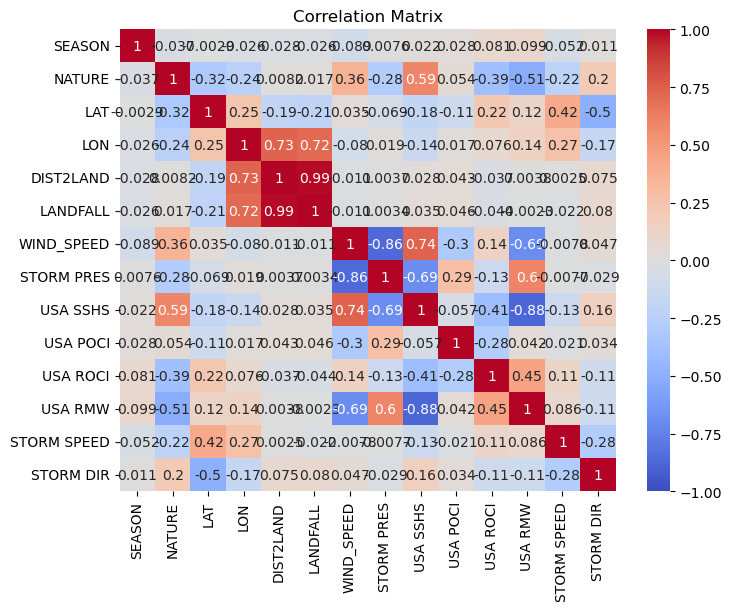

In [96]:
import seaborn as sns

correlation_matrix = final_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Most of attribute do not have good relationship

c:\Users\admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


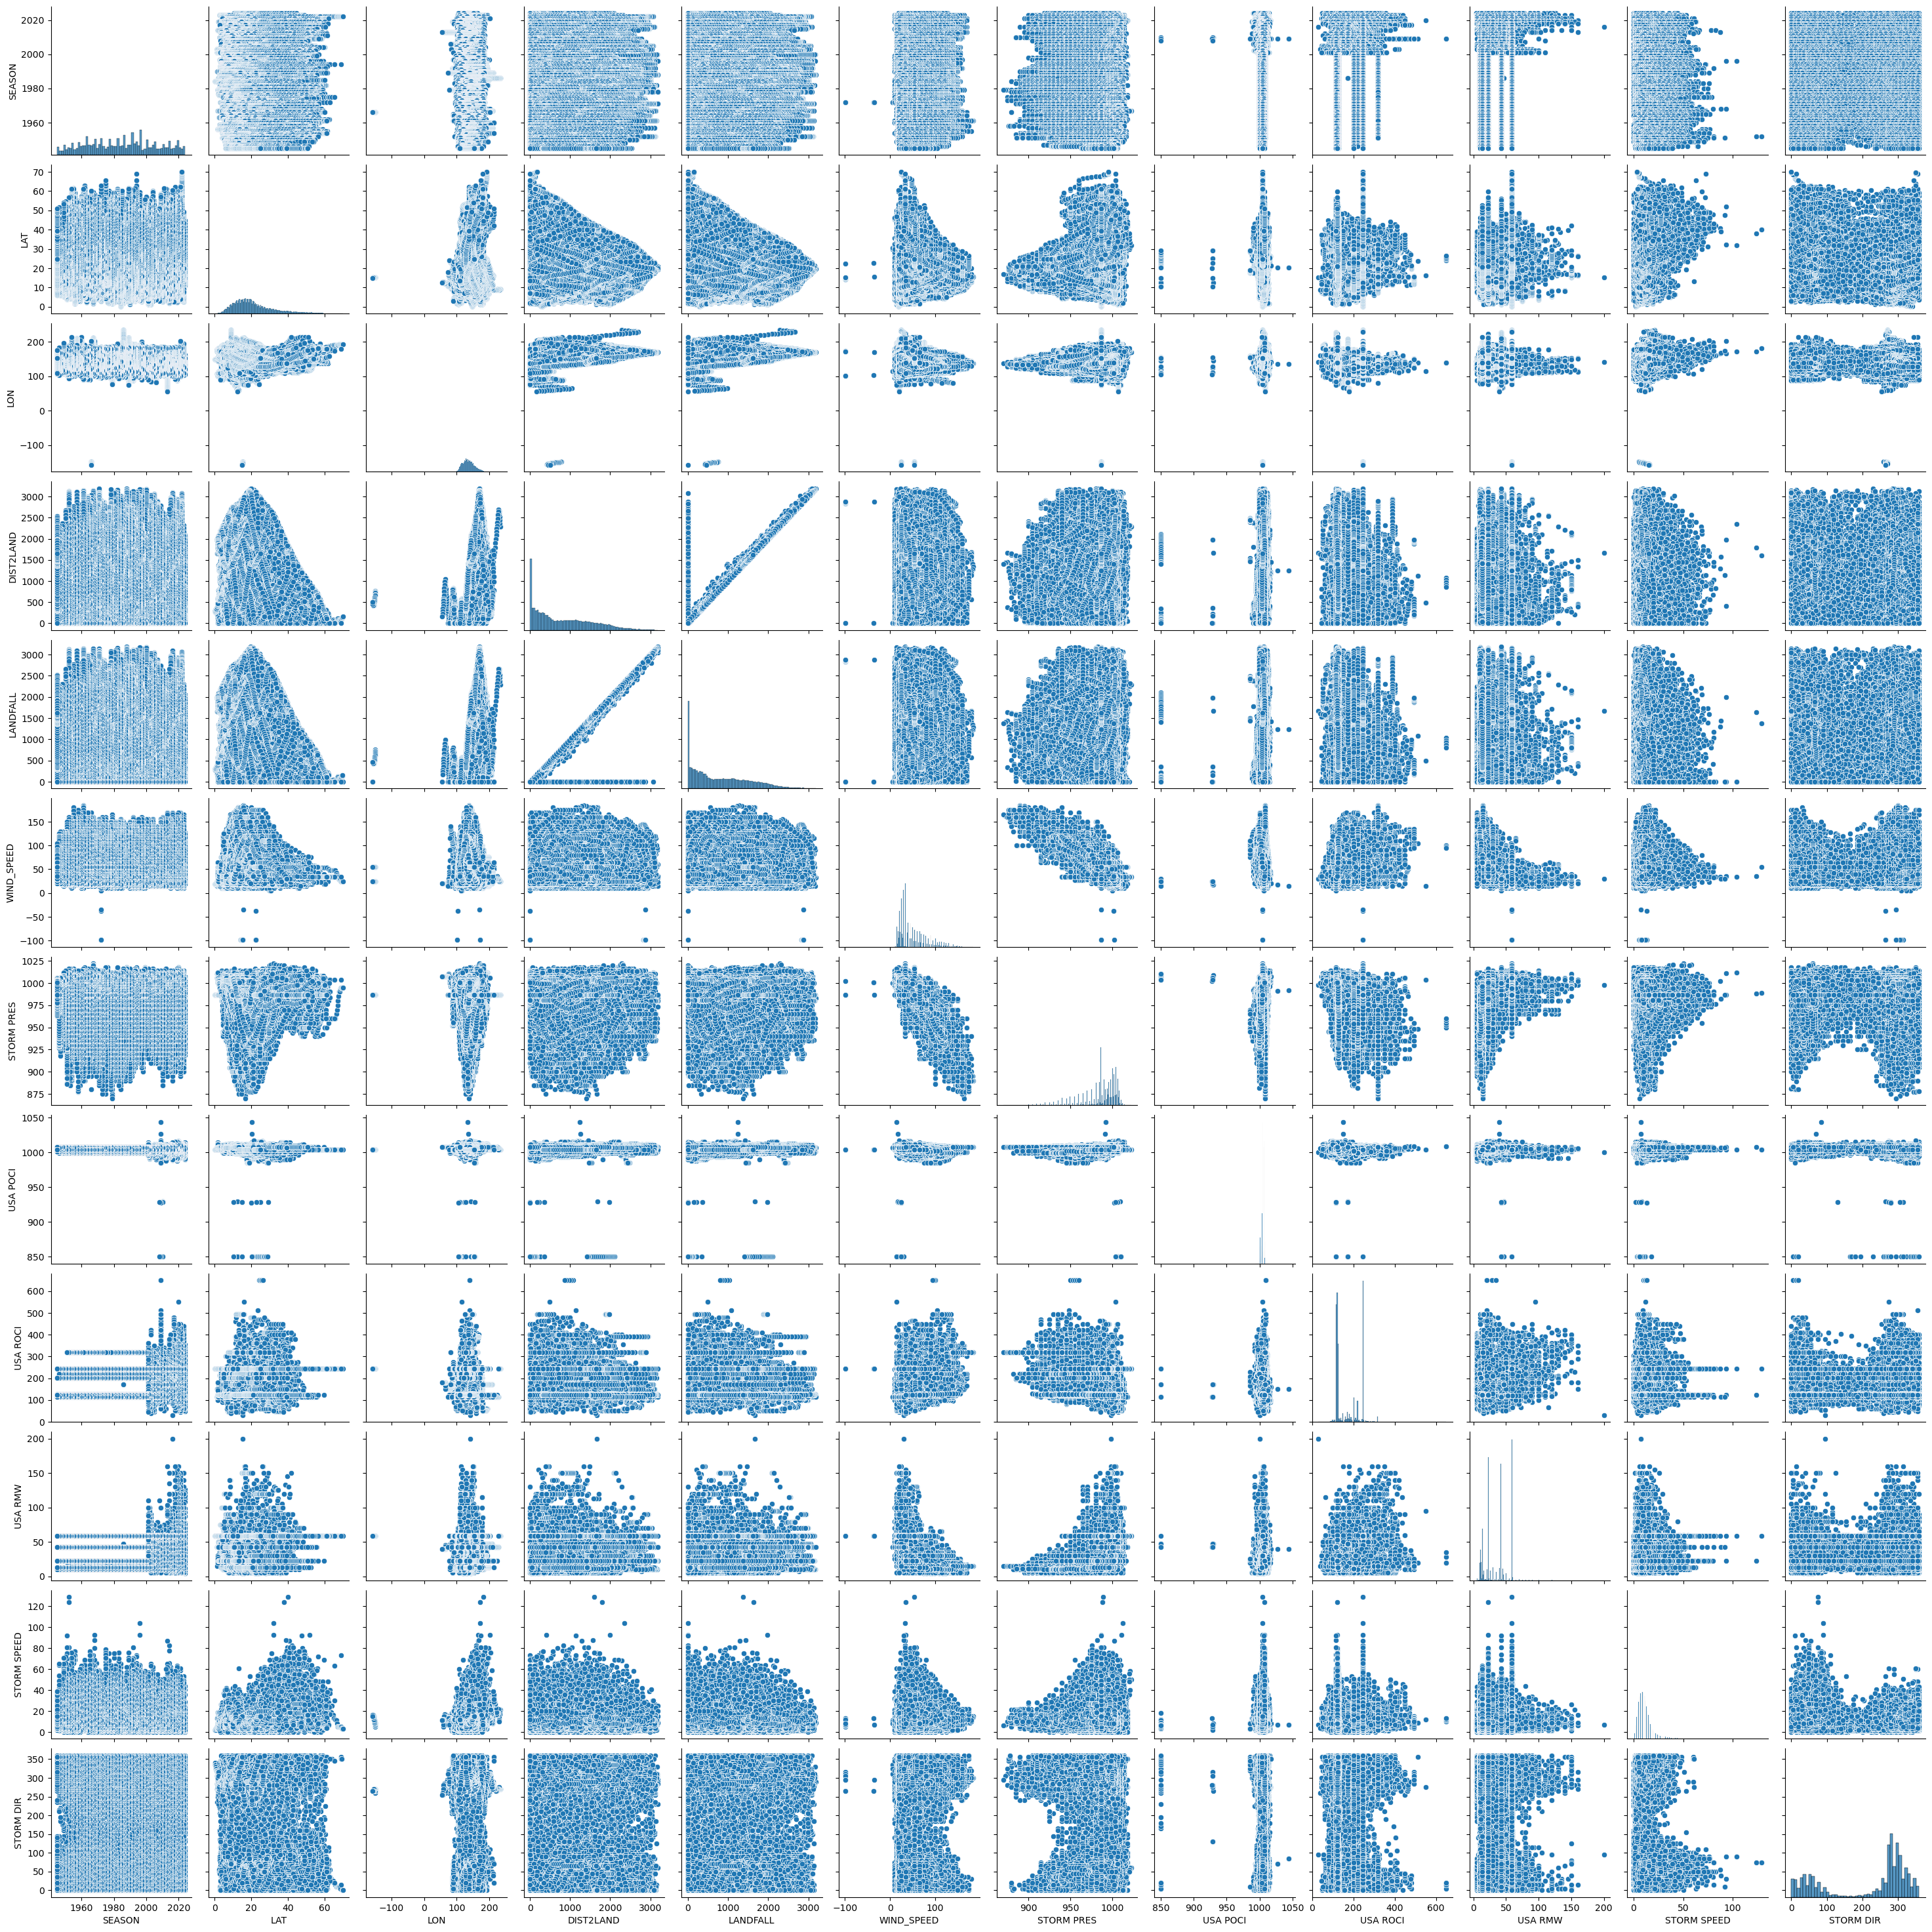

In [97]:
df_numerical = final_data.drop(columns=['NATURE', 'USA SSHS']) 
sns.pairplot(df_numerical)
plt.show()

This data not good for clustering

# Predict storm trajectory and category 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
training_df = pd.read_csv('final_data.csv')

## Split dataset methods for training, testing and evaluate model

- Split dataset for 70% for training and 30% for testing
- In training set, apply 3 validation methods
    - Kfold split
    - Walk forward split
    - Group time series split with gap

In [3]:
from typing import Tuple, List
from sklearn.model_selection import KFold

def split_data(data: pd.DataFrame, train_start_year: int, test_start_year: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Splits data into training and testing sets based on specified start years."""
    train_data = data[data['SEASON'] >= train_start_year]
    train_data = train_data[train_data['SEASON'] < test_start_year] 
    test_data = data[data['SEASON'] >= test_start_year]  
    
    return train_data, test_data

In [4]:
def k_fold_split(train_data: pd.DataFrame, year_range: int) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    years = sorted(train_data['SEASON'].unique())
    n_splits = len(years) // year_range

    folds = []
    for i in range(n_splits):
        val_years = years[i * year_range:(i + 1) * year_range]
        val_fold = train_data[train_data['SEASON'].isin(val_years)]
        train_fold = train_data[~train_data['SEASON'].isin(val_years)]
        
        folds.append((train_fold, val_fold))
    
    return folds

In [5]:
def walk_forward_split(train_data: pd.DataFrame, year_range: int) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    years = sorted(train_data['SEASON'].unique())
    folds = []
    n_splits = len(years) // year_range
    for i in range(n_splits):
        train_years = years[:i + 1]
        test_years = years[i + 1:i + 1 + year_range]
        train_fold = train_data[train_data['SEASON'].isin(train_years)]
        test_fold = train_data[train_data['SEASON'].isin(test_years)]
        
        folds.append((train_fold, test_fold))
    
    return folds


In [7]:

def group_time_series_split_with_gap(data: pd.DataFrame, train_size: int, gap_size: int, test_size: int) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    unique_years = data['SEASON'].unique()
    unique_years.sort()
    n_years = len(unique_years)
    
    folds = []
    start = 0
    
    while True:
        train_start_year = unique_years[start]
        train_end_year = train_start_year + train_size
        gap_end_year = train_end_year + gap_size
        test_start_year = gap_end_year
        test_end_year = test_start_year + test_size
        
        # Exit loop if test end year exceeds available data
        if test_end_year > unique_years[-1]:
            break
        
        # Create train and test dataframes
        train_df = data[(data['SEASON'] >= train_start_year) & (data['SEASON'] < train_end_year)]
        test_df = data[(data['SEASON'] >= test_start_year) & (data['SEASON'] < test_end_year)]
        
        folds.append((train_df, test_df))
        
        # Move to next fold start
        try:
            start = np.where(unique_years == test_end_year)[0][0]
        except IndexError:
            break
    
    return folds


## Metric to evaluate model and tuning parameters


- Using MAE
- Using Haversine distance

$\text{Mean Haversine Distance} = \frac{1}{n} \sum_{i=1}^{n} 2R \cdot \arcsin \left( \sqrt{ \sin^2 \left( \frac{\text{lat}_{i}^{\text{pred}} - \text{lat}_{i}^{\text{true}}}{2} \right) + \cos(\text{lat}_{i}^{\text{true}}) \cdot \cos(\text{lat}_{i}^{\text{pred}}) \cdot \sin^2 \left( \frac{\text{lon}_{i}^{\text{pred}} - \text{lon}_{i}^{\text{true}}}{2} \right) } \right)$

- $R \approx 6371 \, \text{km} $ is Earth's radius.
- $ (\text{lat}_{i}^{\text{true}}, \text{lon}_{i}^{\text{true}}) and (\text{lat}_{i}^{\text{pred}}, \text{lon}_{i}^{\text{pred}})$ are latitude and longtitue at \( i \).


In [2]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances as haversine_dist

def mean_haversine_distance(true_df, pred_df):
    true_points = np.radians(np.column_stack((true_df['LAT'].values, true_df['LON'].values)))
    pred_points = np.radians(np.column_stack((pred_df['LAT'].values, pred_df['LON'].values)))
    distances = [
        haversine_dist([true_points[i]], [pred_points[i]])[0][0] * 6371  
        for i in range(len(true_points))
    ]

    mean_distance = np.mean(distances)
    return mean_distance



# Using random forest

## Predict LAT and LON of storm 

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error

train_data, test_data = split_data(data=training_df, train_start_year=1945, test_start_year=2000)

random_forest_regression = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)

X_train = train_data.drop(columns = ['LAT', 'LON'])
Y_train = train_data[['LAT', 'LON']]

random_forest_regression.fit(X_train, Y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   47.8s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [10]:
X_test = test_data.drop(columns = ['LAT', 'LON'])
Y_test = test_data[['LAT', 'LON']]

random_forest_prediction = random_forest_regression.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


In [15]:
mae_lat = mean_absolute_error(Y_test['LAT'], random_forest_prediction[:, 0])
mae_lon = mean_absolute_error(Y_test['LON'], random_forest_prediction[:, 1])

print(f"Mean Absolute Error for LAT: {mae_lat}")
print(f"Mean Absolute Error for LON: {mae_lon}")
random_forest_prediction_to_dataframe = pd.DataFrame(random_forest_prediction, columns=['LAT', 'LON'])
print(f'Mean haversine distance error: {mean_haversine_distance(true_df = Y_test, pred_df = random_forest_prediction_to_dataframe)}')

Mean Absolute Error for LAT: 4.926282084072047
Mean Absolute Error for LON: 6.462165664807102
Mean haversine distance error: 922.673981090901


When using random forest with no tuning, mean haversine distance error is 922km

# Improve model with hyperparameter tuning, regularization and optimization

## Hyperparameter tunning in random forest regressor

Using Bayesian Optimization:
- Random Forest is a non-linear model.
- For complex and large datasets, Grid Search and Random Search are not ideal.
- Only the range of some parameters needs to be specified, not the exact values.

Define training set (70%) and testing test (30%)

In [9]:
data = pd.read_csv('final_data.csv')

In [25]:
train_data, test_data = split_data(data=data, train_start_year=1945, test_start_year=2000)

Define baynesian optimization

In [20]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

def tune_hyperparameter_bayesian_optimization(data: list, param_bounds: dict, n_iter: int):
    def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_samples_split = int(min_samples_split)
        min_samples_leaf = int(min_samples_leaf)
        
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        
        mean_haversine_distance_value = float('inf')
        
        for train_data, test_data in data:
            X_train = train_data.drop(columns=['LAT', 'LON'])
            Y_train = train_data[['LAT', 'LON']]
            X_test = test_data.drop(columns=['LAT', 'LON'])
            Y_test = test_data[['LAT', 'LON']]
            rf.fit(X_train, Y_train)
            y_pred = rf.predict(X_test)
            y_pred = pd.DataFrame(y_pred, columns=['LAT', 'LON'])
            cur_mean_haversine_distance = mean_haversine_distance(true_df=Y_test, pred_df=y_pred)
            
            if cur_mean_haversine_distance < mean_haversine_distance_value:
                mean_haversine_distance_value = cur_mean_haversine_distance

        return -mean_haversine_distance_value

    optimizer = BayesianOptimization(
        f=rf_evaluate,
        pbounds=param_bounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=2, n_iter=n_iter)

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_samples_split'] = int(best_params['min_samples_split'])
    best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
    
    return best_params

# Define parameter bounds
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

k_fold_data = k_fold_split(train_data=train_data, year_range=10)

print(tune_hyperparameter_bayesian_optimization(data=k_fold_data, param_bounds=param_bounds, n_iter=10))

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:   26.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 199 out of 199 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 199 out of 199 | elapsed:   27.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 1         | -842.1    | 14.36     | 9.556     | 7.856     | 199.7     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:   19.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 266 out of 266 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 2         | -836.0    | 8.9       | 2.404     | 2.465     | 266.5     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 266 out of 266 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 266 out of 266 | elapsed:   18.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 3         | -835.8    | 8.893     | 3.616     | 2.861     | 266.2     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:   54.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 296 out of 296 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:   50.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 4         | -832.9    | 30.0      | 10.0      | 10.0      | 296.7     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.0s
[Parall

| 5         | -864.4    | 30.0      | 1.0       | 2.0       | 50.0      |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 6         | -914.3    | 5.0       | 10.0      | 10.0      | 300.0     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:   58.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 277 out of 277 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 277 out of 277 | elapsed:   55.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 7         | -834.3    | 30.0      | 6.268     | 5.975     | 277.2     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 253 out of 253 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 253 out of 253 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 8         | -853.7    | 27.37     | 1.613     | 2.028     | 253.1     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:   10.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 224 out of 224 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

| 9         | -914.4    | 5.0       | 10.0      | 10.0      | 224.4     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   33.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   30.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parall

| 10        | -833.6    | 21.58     | 9.212     | 6.199     | 180.7     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parall

| 11        | -914.5    | 5.0       | 1.0       | 2.0       | 180.6     |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:   34.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 191 out of 191 | elapsed:   32.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 191 out of 191 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parall

| 12        | -833.2    | 29.4      | 10.0      | 10.0      | 191.4     |
{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 296}


Most optimal hyperparameter is {'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 296}

## Testing tuned hyperparameter for regressor

### Using Kfold method

Apply optimal hyperparameter on model then using K folds for testing

In [21]:
tuning_model = RandomForestRegressor(n_estimators=296, max_depth=30, min_samples_leaf=10, min_samples_split=10, verbose=1, n_jobs=-1, random_state=42)
total_mae_lat = 0
total_mae_lon = 0

test_count = 0
k_fold_data = k_fold_split(train_data=train_data, year_range=10)
total_loss_distance = 0

for train_data, test_data in k_fold_data:
    X_train = train_data.drop(columns=['LAT', 'LON'])
    Y_train = train_data[['LAT', 'LON']]
    X_test = test_data.drop(columns=['LAT', 'LON'])
    Y_test = test_data[['LAT', 'LON']]
    tuning_model.fit(X_train, Y_train)
    y_pred = tuning_model.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=['LAT', 'LON'])

    total_loss_distance += mean_haversine_distance(true_df=Y_test, pred_df=y_pred_df)

    total_mae_lat += mean_absolute_error(Y_test['LAT'], y_pred_df['LAT'])
    total_mae_lon += mean_absolute_error(Y_test['LON'], y_pred_df['LON'])
    
    test_count += 1

average_loss_distance = total_loss_distance / test_count
average_mae_lat = total_mae_lat / test_count
average_mae_lon = total_mae_lon / test_count
print(f'Total loss (mean haversine distance) on training set using k-fold split: {average_loss_distance}')
print(f'Mean Absolute Error for LAT: {average_mae_lat}')
print(f'Mean Absolute Error for LON: {average_mae_lon}')


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:   52.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 296 out of 296 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:   51.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

Total loss (mean haversine distance) on training set using k-fold split: 867.0985804775148
Mean Absolute Error for LAT: 4.4507454682043655
Mean Absolute Error for LON: 6.257993967118284


Total loss (mean haversine distance) on training set using k-fold split: 867.0985804775148

Mean Absolute Error for LAT: 4.4507454682043655

Mean Absolute Error for LON: 6.257993967118284

### Using walk forward spliting method

In [26]:
tuning_model = RandomForestRegressor(n_estimators=296, max_depth=30, min_samples_leaf=10, min_samples_split=10, verbose=1, n_jobs=-1, random_state=42)
total_mae_lat = 0
total_mae_lon = 0

test_count = 0
walk_forward_split_data = walk_forward_split(train_data=train_data, year_range=10)
total_loss_distance = 0

for train_data, test_data in walk_forward_split_data:
    X_train = train_data.drop(columns=['LAT', 'LON'])
    Y_train = train_data[['LAT', 'LON']]
    X_test = test_data.drop(columns=['LAT', 'LON'])
    Y_test = test_data[['LAT', 'LON']]
    tuning_model.fit(X_train, Y_train)
    y_pred = tuning_model.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=['LAT', 'LON'])
    total_loss_distance += mean_haversine_distance(true_df=Y_test, pred_df=y_pred_df)
    total_mae_lat += mean_absolute_error(Y_test['LAT'], y_pred_df['LAT'])
    total_mae_lon += mean_absolute_error(Y_test['LON'], y_pred_df['LON'])
    
    test_count += 1

average_loss_distance = total_loss_distance / test_count
average_mae_lat = total_mae_lat / test_count
average_mae_lon = total_mae_lon / test_count

print(f'Total loss (mean haversine distance) on training set using walk forward split: {average_loss_distance}')
print(f'Mean Absolute Error for LAT: {average_mae_lat}')
print(f'Mean Absolute Error for LON: {average_mae_lon}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 296 out of 296 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

Total loss (mean haversine distance) on training set using walk forward split: 1078.7983205290548
Mean Absolute Error for LAT: 5.989490392627627
Mean Absolute Error for LON: 7.625617860329831


Total loss (mean haversine distance) on training set using walk forward split: 1078.7983205290548

Mean Absolute Error for LAT: 5.989490392627627

Mean Absolute Error for LON: 7.625617860329831

### Using group time series split with gap

In [28]:
data = pd.read_csv('final_data.csv')
train_data, test_data = split_data(data=data, train_start_year=1945, test_start_year=2000)

In [29]:
tuning_model_group_time_series_split_with_gap = RandomForestRegressor(n_estimators=296, max_depth=30, min_samples_leaf=10, min_samples_split=10, verbose=1, n_jobs=-1, random_state=42)
total_mae_lat = 0
total_mae_lon = 0

test_count = 0
group_time_series_split_with_gap_data = group_time_series_split_with_gap(data=train_data, train_size=5, gap_size=2, test_size=3)
total_loss_distance = 0

for train_data, test_data in group_time_series_split_with_gap_data:
    X_train = train_data.drop(columns=['LAT', 'LON'])
    Y_train = train_data[['LAT', 'LON']]
    X_test = test_data.drop(columns=['LAT', 'LON'])
    Y_test = test_data[['LAT', 'LON']]
    
    # Fit the model
    tuning_model_group_time_series_split_with_gap.fit(X_train, Y_train)
    
    # Make predictions
    y_pred = tuning_model_group_time_series_split_with_gap.predict(X_test)
    y_pred_df = pd.DataFrame(y_pred, columns=['LAT', 'LON'])
    
    # Calculate mean haversine distance
    total_loss_distance += mean_haversine_distance(true_df=Y_test, pred_df=y_pred_df)
    
    # Calculate MAE for LAT and LON
    total_mae_lat += mean_absolute_error(Y_test['LAT'], y_pred_df['LAT'])
    total_mae_lon += mean_absolute_error(Y_test['LON'], y_pred_df['LON'])
    
    test_count += 1

# Compute the average results
average_loss_distance = total_loss_distance / test_count
average_mae_lat = total_mae_lat / test_count
average_mae_lon = total_mae_lon / test_count

# Print the results
print(f'Total loss (mean haversine distance) on training set with group time series split and gap: {average_loss_distance}')
print(f'Mean Absolute Error for LAT: {average_mae_lat}')
print(f'Mean Absolute Error for LON: {average_mae_lon}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    2.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 296 out of 296 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    3.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 task

Total loss (mean haversine distance) on training set with group time series split and gap: 1017.1114382183108
Mean Absolute Error for LAT: 5.233201315895549
Mean Absolute Error for LON: 7.3101200811361995


Total loss (mean haversine distance) on training set with group time series split and gap: 1017.1114382183108

Mean Absolute Error for LAT: 5.233201315895549

Mean Absolute Error for LON: 7.3101200811361995

### Check on test set

In [30]:
train_data, test_data = split_data(data=data, train_start_year=1945, test_start_year=2000)
X_train = train_data.drop(columns=['LAT', 'LON'])
Y_train = train_data[['LAT', 'LON']]
X_test = test_data.drop(columns=['LAT', 'LON'])
Y_test = test_data[['LAT', 'LON']]
model = RandomForestRegressor(n_estimators=296, max_depth=30, min_samples_leaf=10, min_samples_split=10, verbose=1, n_jobs=-1, random_state=42)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=['LAT', 'LON'])
total_loss_distance = mean_haversine_distance(true_df=Y_test, pred_df=y_pred_df)

mae_lat = mean_absolute_error(Y_test['LAT'], y_pred_df['LAT'])
mae_lon = mean_absolute_error(Y_test['LON'], y_pred_df['LON'])

print(f'Total loss (mean haversine distance) on test set: {total_loss_distance}')
print(f'Mean Absolute Error for LAT: {mae_lat}')
print(f'Mean Absolute Error for LON: {mae_lon}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:   57.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 296 out of 296 | elapsed:    0.4s finished


Total loss (mean haversine distance) on test set: 875.2430731592369
Mean Absolute Error for LAT: 4.662307667047915
Mean Absolute Error for LON: 6.142881757691371


Total loss (mean haversine distance) on test set: 875.2430731592369

Mean Absolute Error for LAT: 4.662307667047915

Mean Absolute Error for LON: 6.142881757691371

## Using gradient boosting with XGBoost

For solving the problem of overfitting in predicting the category of storms and underfitting in forecasting storm trajectories.

In [10]:
from xgboost import XGBRegressor

data = pd.read_csv('final_data.csv')
train_data, train_data = split_data(data=data, train_start_year=1945, test_start_year=2000)

Apply baynesian optimization for tuning parameters

In [11]:
def baynesian_optimization_xgboostregressor(data: list, param_bounds: dict, n_iter: int):
    def xgb_regressor_evaluate(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda):
        model = XGBRegressor(
            learning_rate=learning_rate,
            max_depth=int(max_depth),
            n_estimators=int(n_estimators),
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        )

In [35]:
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
import pandas as pd


def tune_hyperparameter_bayesian_optimization_xgb(data: list, param_bounds: dict, n_iter: int):
    def xgb_evaluate(learning_rate, max_depth, n_estimators, min_child_weight, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda):
        n_estimators = int(n_estimators)
        max_depth = int(max_depth)
        min_child_weight = int(min_child_weight)

        xgb = XGBRegressor(
            learning_rate=learning_rate,
            max_depth=max_depth,
            n_estimators=n_estimators,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=1
        )
        
        mean_haversine_distance_value = float('inf')

        for train_data, test_data in data:
            X_train = train_data.drop(columns=['LAT', 'LON'])
            Y_train = train_data[['LAT', 'LON']]
            X_test = test_data.drop(columns=['LAT', 'LON'])
            Y_test = test_data[['LAT', 'LON']]

            xgb.fit(X_train, Y_train)
            y_pred = xgb.predict(X_test)
            y_pred = pd.DataFrame(y_pred, columns=['LAT', 'LON'])
            
            cur_mean_haversine_distance = mean_haversine_distance(true_df=Y_test, pred_df=y_pred)

            if cur_mean_haversine_distance < mean_haversine_distance_value:
                mean_haversine_distance_value = cur_mean_haversine_distance

        return -mean_haversine_distance_value

    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds=param_bounds,
        random_state=42,
        verbose=2
    )

    optimizer.maximize(init_points=2, n_iter=n_iter)

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['min_child_weight'] = int(best_params['min_child_weight'])
    
    return best_params

param_bounds = {
    'learning_rate': (0.01, 0.5),
    'max_depth': (3, 10),
    'n_estimators': (50, 300),
    'min_child_weight': (1, 20),
    'subsample': (0, 1.0),
    'colsample_bytree': (0, 1.0),
    'gamma': (0, 20),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 20)
}

best_params_xgb = tune_hyperparameter_bayesian_optimization_xgb(data=k_fold_data, param_bounds=param_bounds, n_iter=50)
print("Best parameters found for XGBoost:", best_params_xgb)


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -865.7    | 0.3745    | 19.01     | 0.3687    | 7.191     | 3.964     | 89.0      | 0.05808   | 17.32     | 0.6011    |
| 2         | -904.1    | 0.7081    | 0.4117    | 0.4853    | 8.827     | 5.034     | 95.46     | 0.1834    | 6.085     | 0.5248    |
| 3         | -887.7    | 0.2405    | 19.2      | 0.4104    | 6.457     | 4.559     | 88.87     | 0.2958    | 16.49     | 0.5331    |
| 4         | -886.1    | 0.5862    | 13.95     | 0.4288    | 8.532     | 9.952     | 146.5     | 0.3951    | 9.747     | 0.7193    |
| 5         | -874.9    | 0.1872    | 12.67     | 0.4973    | 3.653     | 16.2      | 142.0     | 0.6065    | 12.48     | 0.07745   |
| 6         | -936.3    | 0.6142    | 5.689     | 0.4138    | 

Best parameters found for XGBoost: {'colsample_bytree': 0.6802196686020232, 'gamma': 18.11993286052594, 'learning_rate': 0.11355109712259887, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 85, 'reg_alpha': 0.0, 'reg_lambda': 18.991164507244964, 'subsample': 0.9165800983633859}

## Testing XGBoost model

Testing zone

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

data = pd.read_csv('final_data.csv')


### Using Kfold

In [13]:
features = ['DIST2LAND', 'STORM PRES', 'STORM SPEED', 'WIND_SPEED', 'STORM DIR', 'USA POCI', 'USA ROCI', 'USA RMW']
target_lat = 'LAT'
target_lon = 'LON'

mae_lat_scores = []
mae_lon_scores = []
haversine_dist_list = [] 

Kfold_data = k_fold_split(train_data=data, year_range=10)
for train_data, test_data in Kfold_data:
    X_train = train_data[features]
    X_test = test_data[features]
    y_train_lat = train_data[target_lat]
    y_test_lat = test_data[target_lat]
    y_train_lon = train_data[target_lon]
    y_test_lon = test_data[target_lon]

    model_lat = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lat.fit(X_train, y_train_lat)

    model_lon = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lon.fit(X_train, y_train_lon)

    y_pred_lat = model_lat.predict(X_test)
    y_pred_lon = model_lon.predict(X_test)

    y_test = pd.DataFrame({'LAT': y_test_lat, 'LON': y_test_lon})
    y_pred = pd.DataFrame({'LAT': y_pred_lat, 'LON': y_pred_lon})

    mae_lat = mean_absolute_error(y_test['LAT'], y_pred['LAT'])
    mae_lon = mean_absolute_error(y_test['LON'], y_pred['LON'])
    mae_lat_scores.append(mae_lat)
    mae_lon_scores.append(mae_lon)

    haversine_dist_list.append(mean_haversine_distance(y_test, y_pred))

avg_mae_lat = np.mean(mae_lat_scores)
avg_mae_lon = np.mean(mae_lon_scores)
avg_haversine_distance = np.mean(haversine_dist_list)

print("Average MAE for LAT:", avg_mae_lat)
print("Average MAE for LON:", avg_mae_lon)
print("Average Mean Haversine Distance:", avg_haversine_distance)


Average MAE for LAT: 4.547028794657063
Average MAE for LON: 6.362500792726832
Average Mean Haversine Distance: 882.4621860716416


### Using walk forward spliting method

In [14]:
features = ['DIST2LAND', 'STORM PRES', 'STORM SPEED', 'WIND_SPEED', 'STORM DIR', 'USA POCI', 'USA ROCI', 'USA RMW', 'LAT', 'LON']
target_lat = 'LAT'
target_lon = 'LON'

mae_lat_scores = []
mae_lon_scores = []
haversine_dist_list = [] 

walk_forward_split_data = walk_forward_split(train_data=data, year_range=10)
for train_data, test_data in Kfold_data:
    X_train = train_data[features]
    X_test = test_data[features]
    y_train_lat = train_data[target_lat]
    y_test_lat = test_data[target_lat]
    y_train_lon = train_data[target_lon]
    y_test_lon = test_data[target_lon]

    model_lat = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lat.fit(X_train, y_train_lat)

    model_lon = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lon.fit(X_train, y_train_lon)

    y_pred_lat = model_lat.predict(X_test)
    y_pred_lon = model_lon.predict(X_test)

    y_test = pd.DataFrame({'LAT': y_test_lat, 'LON': y_test_lon})
    y_pred = pd.DataFrame({'LAT': y_pred_lat, 'LON': y_pred_lon})

    mae_lat = mean_absolute_error(y_test['LAT'], y_pred['LAT'])
    mae_lon = mean_absolute_error(y_test['LON'], y_pred['LON'])
    mae_lat_scores.append(mae_lat)
    mae_lon_scores.append(mae_lon)

    haversine_dist_list.append(mean_haversine_distance(y_test, y_pred))

avg_mae_lat = np.mean(mae_lat_scores)
avg_mae_lon = np.mean(mae_lon_scores)
avg_haversine_distance = np.mean(haversine_dist_list)

print("Average MAE for LAT:", avg_mae_lat)
print("Average MAE for LON:", avg_mae_lon)
print("Average Mean Haversine Distance:", avg_haversine_distance)


Average MAE for LAT: 0.18100377784741534
Average MAE for LON: 0.5677431952609239
Average Mean Haversine Distance: 64.24510652891583


### Using group time series split with gap

In [15]:
features = ['DIST2LAND', 'STORM PRES', 'STORM SPEED', 'WIND_SPEED', 'STORM DIR', 'USA POCI', 'USA ROCI', 'USA RMW', 'LAT', 'LON']
target_lat = 'LAT'
target_lon = 'LON'

mae_lat_scores = []
mae_lon_scores = []
haversine_dist_list = [] 

group_time_series_split_with_gap_data = group_time_series_split_with_gap(data=train_data, train_size=5, gap_size=2, test_size=3)
for train_data, test_data in group_time_series_split_with_gap_data:
    X_train = train_data[features]
    X_test = test_data[features]
    y_train_lat = train_data[target_lat]
    y_test_lat = test_data[target_lat]
    y_train_lon = train_data[target_lon]
    y_test_lon = test_data[target_lon]

    model_lat = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lat.fit(X_train, y_train_lat)

    model_lon = XGBRegressor(
        colsample_bytree=0.6802196686020232,
        gamma=18.11993286052594,
        learning_rate=0.11355109712259887,
        max_depth=9,
        min_child_weight=2,
        n_estimators=85,
        reg_alpha=0,
        reg_lambda=18.991164507244964,
        subsample=0.9165800983633859,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    model_lon.fit(X_train, y_train_lon)

    y_pred_lat = model_lat.predict(X_test)
    y_pred_lon = model_lon.predict(X_test)

    y_test = pd.DataFrame({'LAT': y_test_lat, 'LON': y_test_lon})
    y_pred = pd.DataFrame({'LAT': y_pred_lat, 'LON': y_pred_lon})

    mae_lat = mean_absolute_error(y_test['LAT'], y_pred['LAT'])
    mae_lon = mean_absolute_error(y_test['LON'], y_pred['LON'])
    mae_lat_scores.append(mae_lat)
    mae_lon_scores.append(mae_lon)

    haversine_dist_list.append(mean_haversine_distance(y_test, y_pred))

avg_mae_lat = np.mean(mae_lat_scores)
avg_mae_lon = np.mean(mae_lon_scores)
avg_haversine_distance = np.mean(haversine_dist_list)

print("Average MAE for LAT:", avg_mae_lat)
print("Average MAE for LON:", avg_mae_lon)
print("Average Mean Haversine Distance:", avg_haversine_distance)


Average MAE for LAT: 0.37512041472803276
Average MAE for LON: 1.2256440667702526
Average Mean Haversine Distance: 137.93752838779798


### On test set

Haversine Distance Error (Mean) for Selected Storm Path Segment: 550.28 km


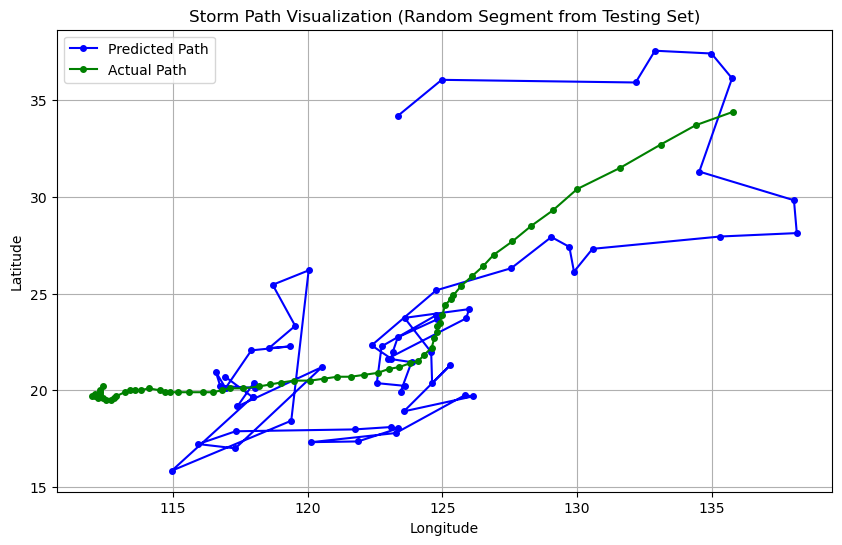

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

file_path = 'final_data.csv'
data = pd.read_csv(file_path)

features = ['DIST2LAND', 'STORM PRES', 'STORM SPEED', 'WIND_SPEED', 'STORM DIR', 'USA POCI', 'USA ROCI', 'USA RMW']
target_intensity = 'WIND_SPEED'
target_direction = 'STORM DIR'
target_lat = 'LAT'
target_lon = 'LON'

data_cleaned = data.dropna(subset=features + [target_intensity, target_direction])


X = data_cleaned[features]
y_intensity = data_cleaned[target_intensity]
y_direction = data_cleaned[target_direction]
y_lat = data_cleaned[target_lat]
y_lon = data_cleaned[target_lon]

train_data = data_cleaned[data_cleaned['SEASON'] < 2000]
test_data = data_cleaned[data_cleaned['SEASON'] >= 2000]

X_train = train_data[features]
X_test = test_data[features]
y_train_lat = train_data[target_lat]
y_test_lat = test_data[target_lat]
y_train_lon = train_data[target_lon]
y_test_lon = test_data[target_lon]

# Training the model for latitude prediction
model_lat = xgb_kfold = XGBRegressor(
    colsample_bytree=0.6802196686020232,
    gamma=18.11993286052594,
    learning_rate=0.11355109712259887,
    max_depth=9,
    min_child_weight=2,
    n_estimators=85,
    reg_alpha=0,
    reg_lambda=18.991164507244964,
    subsample=0.9165800983633859,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
    )
model_lat.fit(X_train, y_train_lat)


model_lon = xgb_kfold = XGBRegressor(
    colsample_bytree=0.6802196686020232,
    gamma=18.11993286052594,
    learning_rate=0.11355109712259887,
    max_depth=9,
    min_child_weight=2,
    n_estimators=85,
    reg_alpha=0,
    reg_lambda=18.991164507244964,
    subsample=0.9165800983633859,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
    )
model_lon.fit(X_train, y_train_lon)

y_pred_lat = model_lat.predict(X_test)
y_pred_lon = model_lon.predict(X_test)

y_test = pd.DataFrame({'LAT': y_test_lat, 'LON': y_test_lon})
y_pred = pd.DataFrame({'LAT': y_pred_lat, 'LON': y_pred_lon})


y_test = pd.DataFrame({'LAT': y_test_lat, 'LON': y_test_lon})
y_pred = pd.DataFrame({'LAT': y_pred_lat, 'LON': y_pred_lon})


landfall_indices = test_data.index[test_data['LANDFALL'] == -1]

if len(landfall_indices) > 2:

    start_idx = np.random.choice(landfall_indices[:-1]) + 1
    end_idx = landfall_indices[landfall_indices > start_idx].min()


    segment_indices = data_cleaned.loc[start_idx:end_idx].index

    actual_lat_series = y_test_lat.loc[segment_indices.intersection(y_test_lat.index)]
    actual_lon_series = y_test_lon.loc[segment_indices.intersection(y_test_lon.index)]
    predicted_lat_series = y_pred_lat[[X_test.index.get_loc(idx) for idx in segment_indices if idx in X_test.index]]
    predicted_lon_series = y_pred_lon[[X_test.index.get_loc(idx) for idx in segment_indices if idx in X_test.index]]

    df_true = pd.DataFrame({'LAT': actual_lat_series, 'LON': actual_lon_series})
    df_pred = pd.DataFrame({'LAT': predicted_lat_series, 'LON': predicted_lon_series})

    haversine_error = mean_haversine_distance(df_true, df_pred)
    print(f"Haversine Distance Error (Mean) for Selected Storm Path Segment: {haversine_error:.2f} km")


    plt.figure(figsize=(10, 6))
    plt.plot(predicted_lon_series, predicted_lat_series, 'bo-', label='Predicted Path', markersize=4)
    plt.plot(actual_lon_series, actual_lat_series, 'go-', label='Actual Path', markersize=4)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Storm Path Visualization (Random Segment from Testing Set)')
    plt.legend()
    plt.grid(True)
    plt.show()